In [23]:
from os.path import dirname, abspath, join
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

file = '2020-02-23-21-36-17.bag'
mpc_data_file = '/home/marcel/ros_ws/analytics_ws/src/performance_monitor/data/acceleration_data2.csv'

dirPath = abspath(dirname(''))
image_file = join(join(join(dirname(dirPath), 'data'),'images'), file+'.png')
data_file = file+'.csv'

data_path = join(join(dirname(dirPath),'data'), data_file)

with open(data_path, 'r') as f:
    data_raw = pd.read_csv(f)

with open(mpc_data_file) as f:
    data_mpc = pd.read_csv(f)    

with open(join(join(dirname(dirPath),'data'), 'path.pkl'), 'rb') as f:
    path = pickle.load(f)

def moving_avg(poses, n):
    N = int(len(poses)/n)
    n = N
    moving_avg = []
    tmp = []
    for i in range(len(poses)):
        tmp.append(poses[i])
        if(i >= N):
            moving_avg.append(np.mean(tmp))
            tmp = []
            N = n+N
    return moving_avg

data_raw_200 = data_raw
path_200 = path
data_raw.head(10)

,time,speed,x_pos,y_pos,deviation,x_lin_acc,y_lin_acc,z_lin_acc
0,1.582490e+09,1.016,-3.591942,-3.899626,0.158980,-0.276527,-1.519105,9.662899
1,1.582490e+09,1.160,-3.591942,-3.899626,0.158980,-0.296878,-1.454463,9.852039
2,1.582490e+09,0.766,-3.591942,-3.899626,0.158980,-0.331594,-1.402988,9.814930
3,1.582490e+09,1.009,-3.591942,-3.899626,0.158980,-0.160410,-1.315600,9.806550
4,1.582490e+09,1.342,-3.591942,-3.899626,0.158980,-0.122103,-1.294053,9.771834
5,1.582490e+09,1.153,-3.591942,-3.899626,0.158980,-0.222658,-1.480799,9.413905
6,1.582490e+09,1.213,-3.591942,-3.899626,0.158980,-0.244206,-1.577763,9.419890
7,1.582490e+09,0.864,-3.643164,-3.962529,0.156713,-0.026336,-1.485587,9.550373
8,1.582490e+09,0.955,-3.643164,-3.962529,0.156713,-0.160410,-1.352710,9.497701
9,1.582490e+09,1.282,-3.661367,-3.984882,0.155907,-0.234629,-0.948094,9.034428


In [24]:
data_mpc.head(10)

,rostime,an,an_nl,at
0,1.582490e+09,0.364590,0.365467,0.632855
1,1.582490e+09,0.661829,0.664482,0.087761
2,1.582490e+09,0.820777,0.825973,0.159637
3,1.582490e+09,0.745185,0.749865,0.228850
4,1.582490e+09,0.819486,0.826261,0.278444
5,1.582490e+09,0.626942,0.629858,-0.381873
6,1.582490e+09,0.762917,0.769616,-0.114410
7,1.582490e+09,0.238031,0.238108,-0.747158
8,1.582490e+09,0.266772,0.266888,-0.733050
9,1.582490e+09,0.722610,0.728964,-0.204887


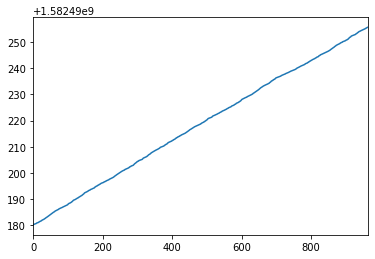

In [25]:
data_mpc['rostime'].plot()

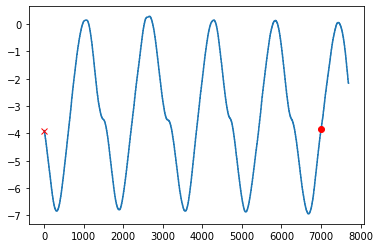

In [26]:
t = data_raw['time']
speed = data_raw['speed']
x_pos = data_raw['x_pos']
y_pos = data_raw['y_pos']

x_acc = data_raw['x_lin_acc']
y_acc = data_raw['y_lin_acc']
z_acc = data_raw['z_lin_acc']


# choose appropriate begining index and end index
plt.plot(y_pos)
ride_end_ind = 7000
ride_start_ind = 0
plt.plot(ride_end_ind, y_pos[ride_end_ind], 'or')
plt.plot(ride_start_ind, y_pos[ride_start_ind], 'xr')

# remove data, where car stands still
time_ = [ti for ti in t[ride_start_ind:ride_end_ind]]
speed_ = [s for s in speed[ride_start_ind:ride_end_ind]]
x_pos_ = [x for x in x_pos[ride_start_ind:ride_end_ind]]
y_pos_ = [y for y in y_pos[ride_start_ind:ride_end_ind]]

x_acc_ = [a for a in x_acc[ride_start_ind:ride_end_ind]]
y_acc_ = [a for a in y_acc[ride_start_ind:ride_end_ind]]
z_acc_ = [a for a in z_acc[ride_start_ind:ride_end_ind]]




path_x = [point['x'] for point in path]
path_y = [point['y'] for point in path]

In [27]:
# make an avarage
x_avg = moving_avg(x_pos_, 1000)
y_avg = moving_avg(y_pos_, 1000)

avg_x_acc = moving_avg(x_acc_, 1000)
avg_y_acc = moving_avg(y_acc_, 1000)
avg_z_acc = moving_avg(z_acc_, 1000)

speed_avg = moving_avg(speed_, 1000)

# Prędkość uśredniona podczas całego przejazdu

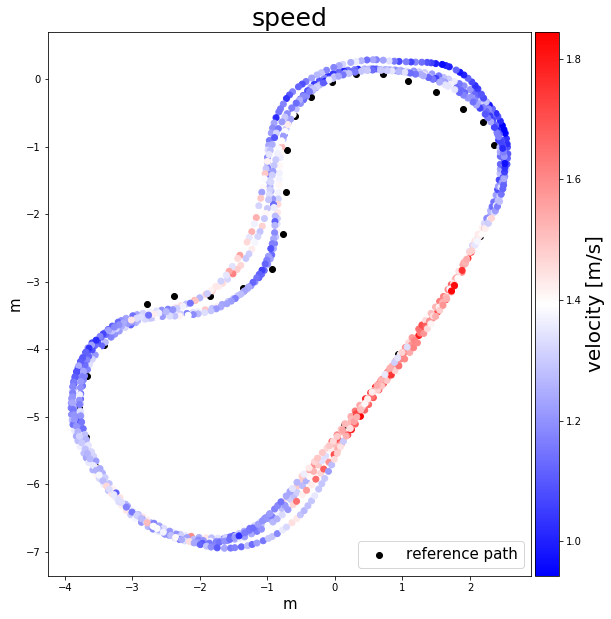

In [28]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('speed', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_avg, y_avg, c=speed_avg, cmap='bwr')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(im, cax=cax)
cb.set_label('velocity [m/s]', fontsize=20)

ax.set_aspect('equal')
#ax.set_ylim(ymin=0)
#ax.set_xlim(xmin=0)
#plt.savefig(image_file)

# Extract turn after long straight

1057
1057
n_pathpoints_in_turn : 6


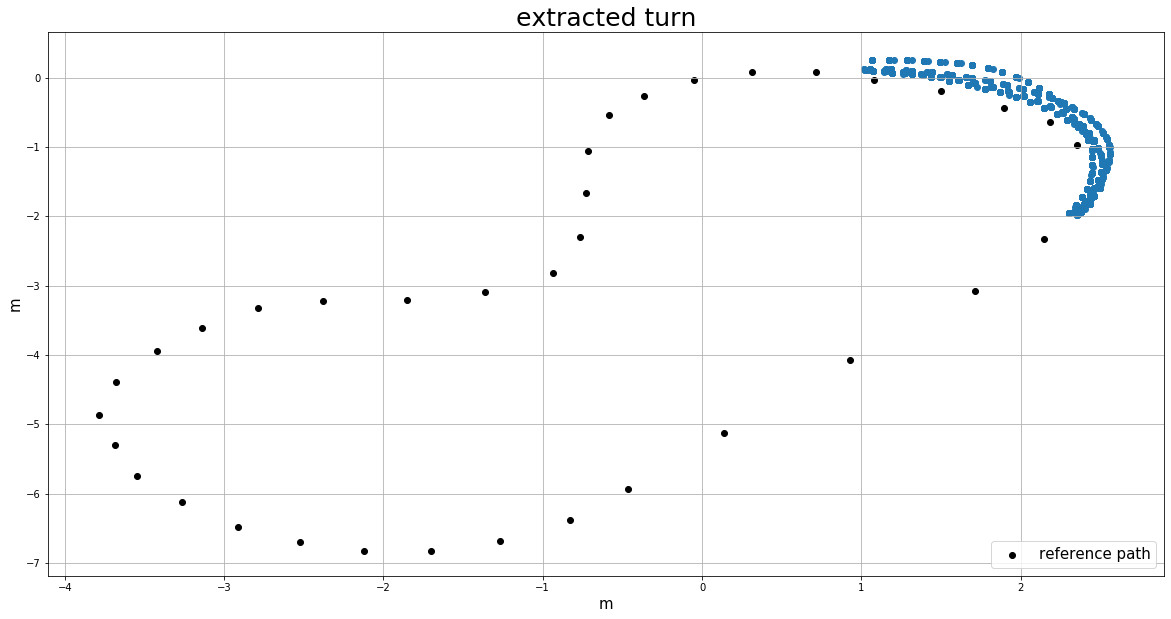

In [29]:
x_cut = 1
y_cut = -2

x_turn = []
y_turn = []
x_acc = []
y_acc = []
z_acc = []
global_idx = []

for i, x,y, xa, ya, za in zip(range(len(x_pos)),x_pos_, y_pos_, x_acc_, y_acc_, z_acc_):
    if(y>y_cut and x>x_cut):
        x_turn.append(x)
        y_turn.append(y)
        x_acc.append(xa)
        y_acc.append(ya)
        z_acc.append(za)
        global_idx.append(i)
print(len(x_turn))
print(len(x_acc))
  
x_acc_1_turn = x_acc
y_acc_1_turn = y_acc
    
n_pathpoints_in_turn = 0
for x,y in zip(path_x, path_y):
    if(y>y_cut and x>x_cut):
          n_pathpoints_in_turn=n_pathpoints_in_turn+1
print('n_pathpoints_in_turn : '+repr(n_pathpoints_in_turn))


fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('extracted turn', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_turn, y_turn)
plt.grid(True)

## separate individual laps from each other

nr of turns: 3


Text(0.5, 1.0, 'lap 3 extracted on first turn')

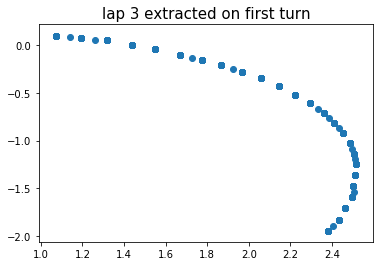

In [30]:

tmp = np.diff(x_turn)>np.max(np.diff(x_turn))/10
print('nr of turns: '+repr(sum(tmp)))
turn_end_indexes = np.argwhere(tmp)
turn_end_indexes = [int(t)+1 for t in turn_end_indexes]

global_end_turn_indexes = [global_idx[i] for i in turn_end_indexes]

turn_1_x = np.split(x_turn, turn_end_indexes)
turn_1_y = np.split(y_turn, turn_end_indexes)
turn_1_x_acc = np.split(x_acc, turn_end_indexes)
turn_1_y_acc = np.split(y_acc, turn_end_indexes)
turn_1_z_acc = np.split(z_acc, turn_end_indexes)

lap_nr = 3

#fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10,5])
#ax1.plot(np.diff(x_turn))
#ax1.set_title('asc')
plt.scatter(turn_1_x[lap_nr], turn_1_y[lap_nr])
plt.title('lap '+ repr(lap_nr)+ ' extracted on first turn', fontsize=15)

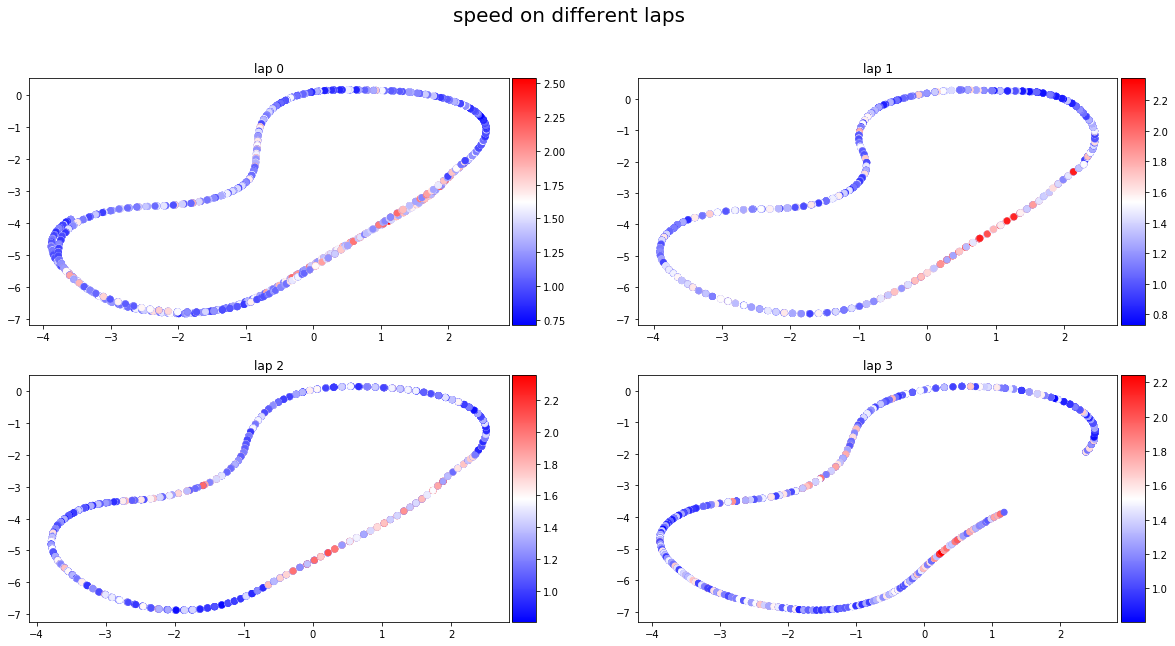

In [31]:
x_split = np.split(x_pos_, global_end_turn_indexes)
y_split = np.split(y_pos_, global_end_turn_indexes)
speed_split = np.split(speed_, global_end_turn_indexes)
x_acc_split = np.split(x_acc_, global_end_turn_indexes)
y_acc_split = np.split(y_acc_, global_end_turn_indexes)

r=1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('speed on different laps', fontsize=20)
for ax, i in zip(axes, range(4)):
   # ax.title('title', fontsize=25)
    #ax.scatter(path_x, path_y, color='black')
    im = ax.scatter(x_split[i][::r], y_split[i][::r], c=speed_split[i][::r], cmap='bwr')
    ax.set_title('lap '+repr(i))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    #cb.set_label('x acceleration [m/s]', fontsize=10)




# Histogramy przyspieszen dla pierwszego zakrętu

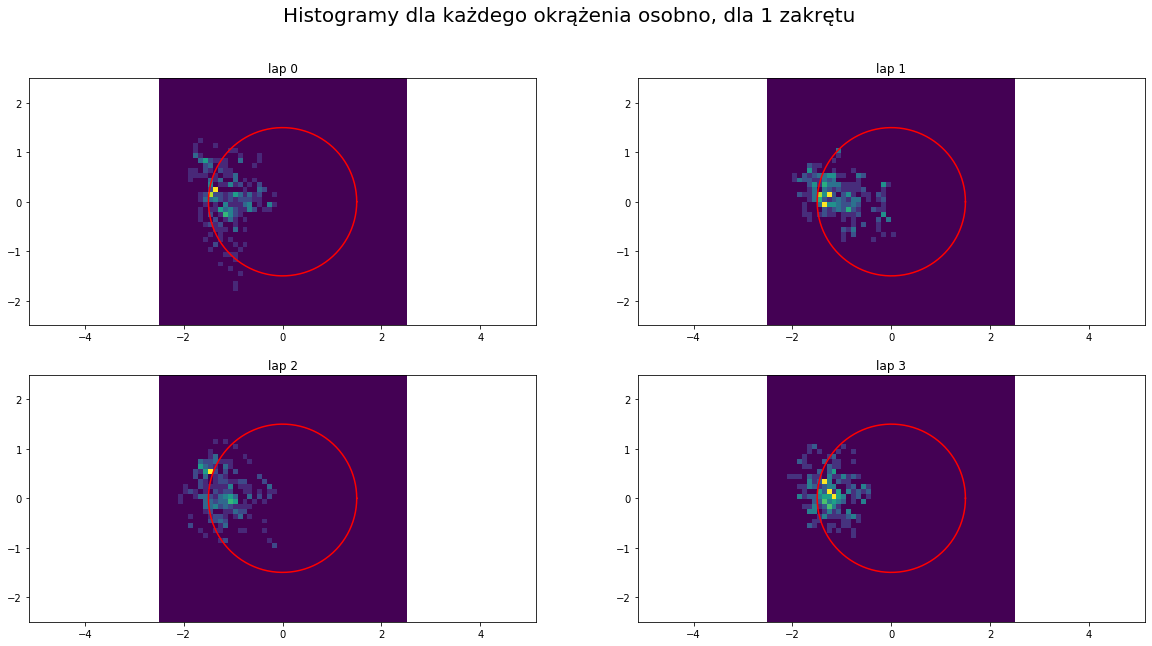

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('Histogramy dla każdego okrążenia osobno, dla 1 zakrętu', fontsize=20)
for ax, i in zip(axes, range(4)):
    ax.hist2d(turn_1_y_acc[i], turn_1_x_acc[i], bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
    ax.set_title('lap '+repr(i))
    an = np.linspace(0, 2*np.pi, 100)
    ax.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
    ax.axis('equal')


Text(0.5, 1.0, 'histogram dla wszystkich okrążeń na pierwszym zakręcie')

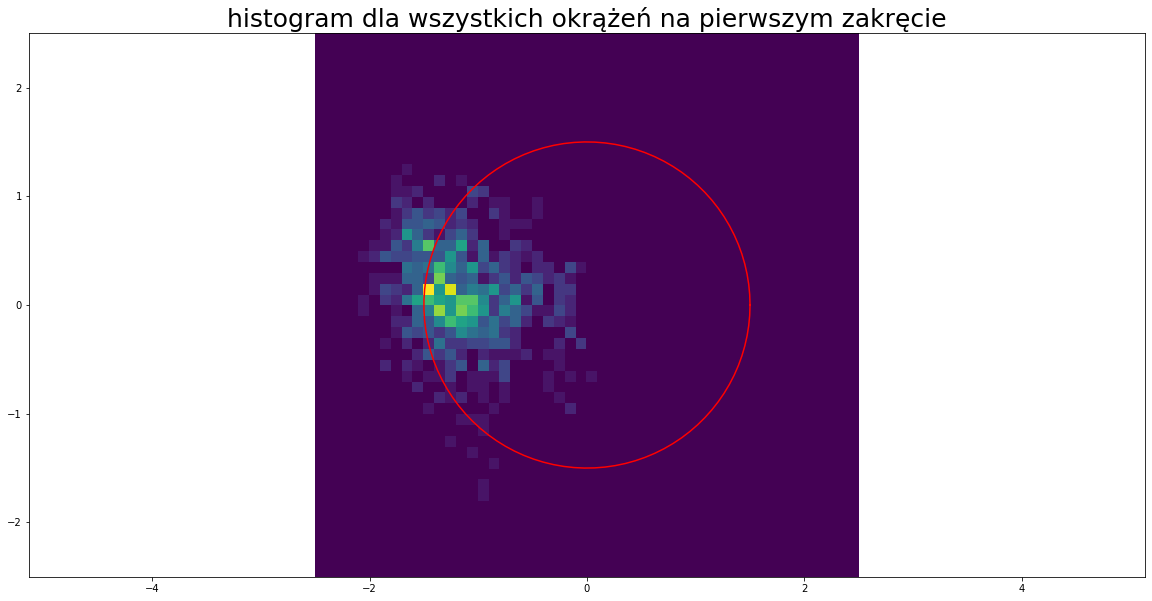

In [33]:
fig = plt.figure(figsize=(20,10))
plt.hist2d(y_acc, x_acc, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
plt.title('lap '+repr(i))
an = np.linspace(0, 2*np.pi, 100)
plt.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
plt.axis('equal')
plt.title('histogram dla wszystkich okrążeń na pierwszym zakręcie', fontsize=25)

#   Ostatni zakręt przed prostą

1356
1356


Text(0.5, 1.0, 'extracted turn')

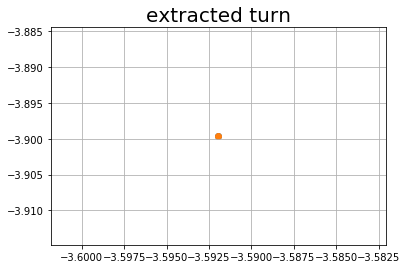

In [34]:
#punkt odcięcia zakrętu
x_cut = -3
y_cut = -3.5

x_turn = []
y_turn = []
x_acc = []
y_acc = []
z_acc = []
global_idx = []

for i, x,y, xa, ya, za in zip(range(len(x_pos)),x_pos, y_pos, x_acc_, y_acc_, z_acc_):
    if(y<y_cut and x<x_cut):
        x_turn.append(x)
        y_turn.append(y)
        x_acc.append(xa)
        y_acc.append(ya)
        z_acc.append(za)
        global_idx.append(i)
print(len(x_turn))
print(len(x_acc))


plt.scatter(x_pos[::10000], y_pos[::10000])
plt.scatter(x_turn[::10000], y_turn[::10000])
plt.grid(True)
plt.title('extracted turn', fontsize=20)

number of turns extracted: 4


(-3.9373170612536925,
 -2.9529151819845216,
 -6.614110041554116,
 -3.755911358674894)

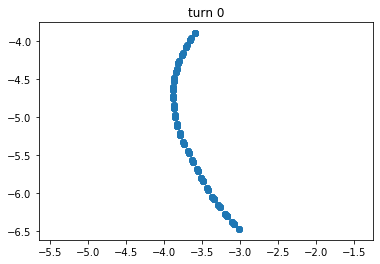

In [35]:
tmp = np.diff(y_turn)>np.max(np.diff(y_turn))/10
print('number of turns extracted: '+repr(sum(tmp)))

turn2_end_indexes = np.argwhere(tmp)
turn2_end_indexes = [int(t)+1 for t in turn2_end_indexes]
global_end_turn2_indexes = [global_idx[i] for i in turn2_end_indexes]

turn_2_x = np.split(x_turn, turn2_end_indexes)
turn_2_y = np.split(y_turn, turn2_end_indexes)
turn_2_x_acc = np.split(x_acc, turn2_end_indexes)
turn_2_y_acc = np.split(y_acc, turn2_end_indexes)
turn_2_z_acc = np.split(z_acc, turn2_end_indexes)

lap_nr = 0

plt.scatter(turn_2_x[lap_nr], turn_2_y[lap_nr])
plt.title('turn '+repr(lap_nr))
plt.axis('equal')

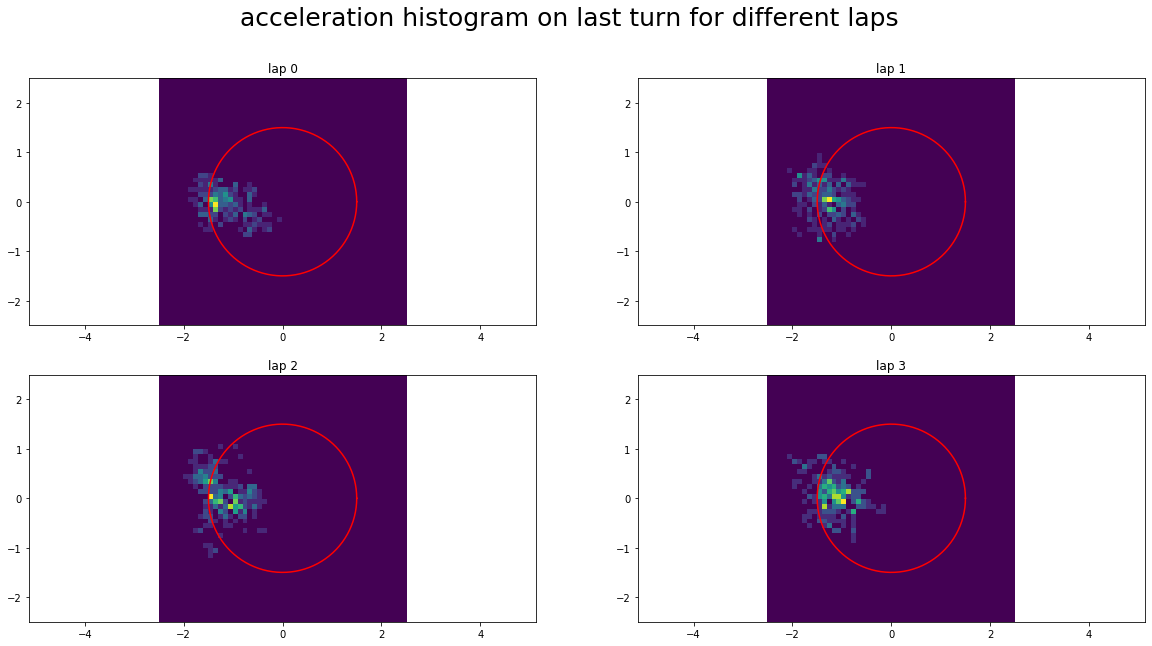

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('acceleration histogram on last turn for different laps', fontsize=25)
for ax, i in zip(axes, range(4)):
    ax.hist2d(turn_2_y_acc[i], turn_2_x_acc[i], bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
    ax.set_title('lap '+repr(i))
    an = np.linspace(0, 2*np.pi, 100)
    ax.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
    ax.axis('equal')


Text(0.5, 1.0, 'rozklad przyspieszen na pierwszym zakręcie')

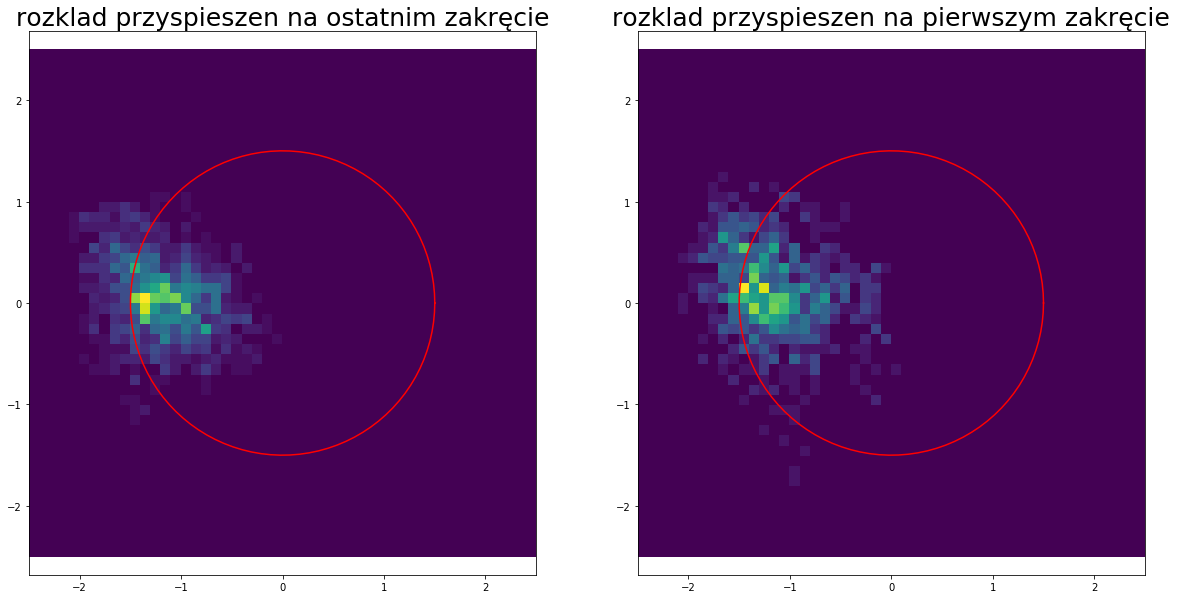

In [37]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,10])

ax1.hist2d(y_acc, x_acc, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
an = np.linspace(0, 2*np.pi, 100)
ax1.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
ax1.axis('equal')
ax1.set_title('rozklad przyspieszen na ostatnim zakręcie', fontsize=25)
#ax1.savefig('21_33_left.jpg')

ax2.hist2d(y_acc_1_turn, x_acc_1_turn, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
ax2.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
ax2.axis('equal')
ax2.set_title('rozklad przyspieszen na pierwszym zakręcie', fontsize=25)

Text(0.5, 1.0, 'rozklad przyspieszen podczas całego przejazdu')

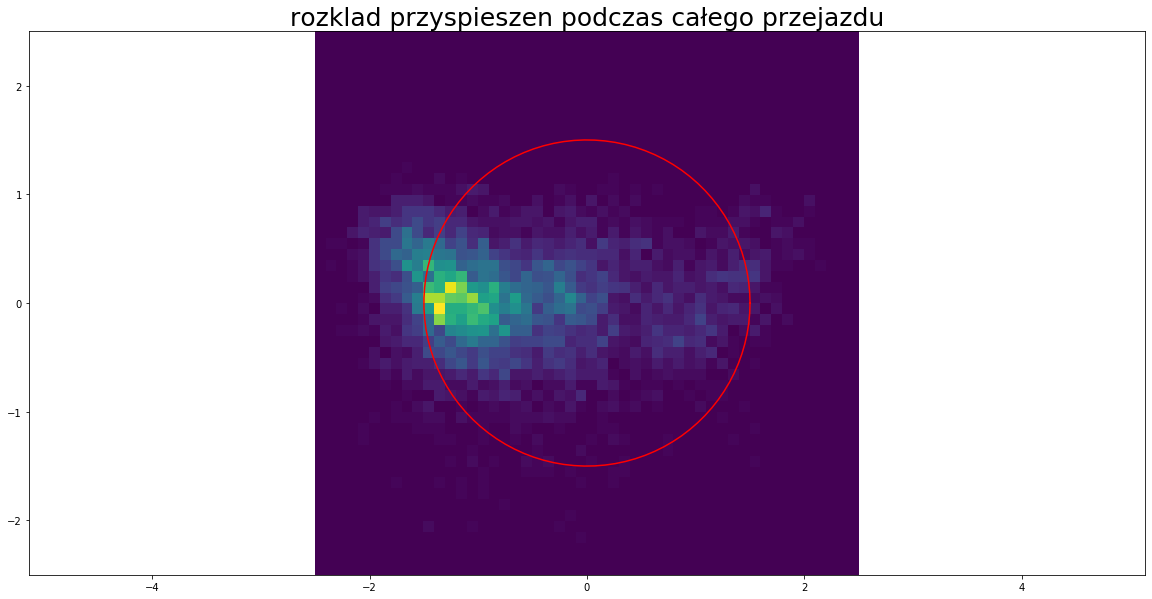

In [38]:
fig = plt.figure(figsize=(20,10))
plt.hist2d(y_acc_, x_acc_, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
plt.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
plt.axis('equal')
plt.title('rozklad przyspieszen podczas całego przejazdu', fontsize=25)

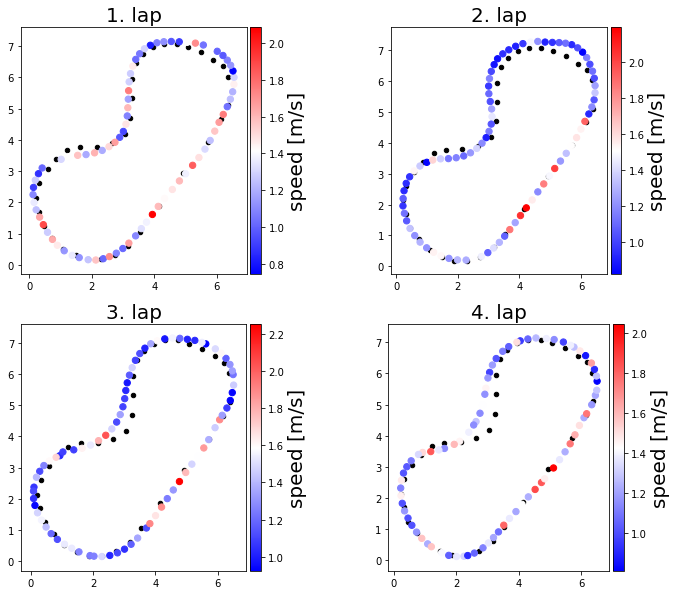

In [144]:
x_offset = 4
y_offset = 7
x_pos_off = [x+x_offset for x in x_pos_]
y_pos_off = [y+y_offset for y in y_pos_]
path_x_off = [x+x_offset for x in path_x]
path_y_off = [y+y_offset for y in path_y]


x_split = np.split(x_pos_off, global_end_turn2_indexes)
y_split = np.split(y_pos_off, global_end_turn2_indexes)
speed_split = np.split(speed_, global_end_turn2_indexes)
x_acc_split = np.split(x_acc_, global_end_turn2_indexes)
y_acc_split = np.split(y_acc_, global_end_turn2_indexes)

r=20

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[12,10])
axes = [ax1, ax2, ax3, ax4]
#fig.suptitle('speed on different laps', fontsize=25)
for ax, i in zip(axes, range(4)):
   # ax.title('title', fontsize=25)
    ax.scatter(path_x_off, path_y_off, color='black', s=20)
    im = ax.scatter(x_split[i][::r], y_split[i][::r], c=speed_split[i][::r], cmap='bwr', s=40)
    ax.set_title(repr(i+1)+ '. lap', fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.axis('equal')
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('speed [m/s]', fontsize=20)
plt.savefig('speed_on_4_laps.png')

# Przebiegi czasowe dla dwóch zakrętów

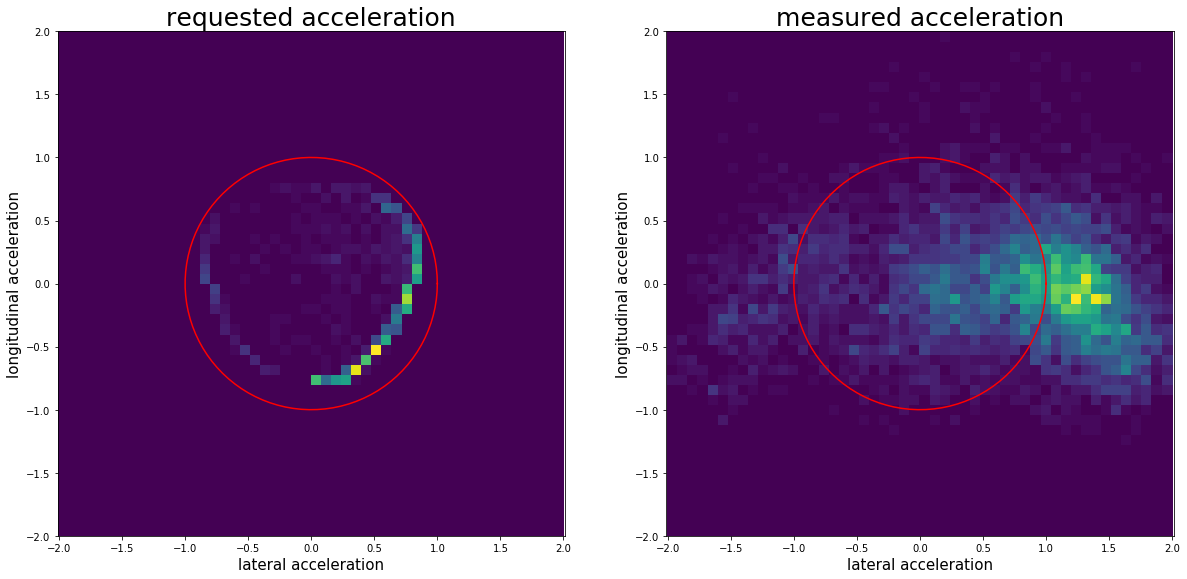

In [122]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,9.28])
ax1.hist2d(data_mpc['an'], data_mpc['at'], bins=50, range=[[-2, 2], [-2, 2]])
ax1.plot(1*np.cos(an), 1*np.sin(an), 'r')
ax1.axis('equal')
ax1.set_xlabel('lateral acceleration', fontsize=15)
ax1.set_ylabel('longitudinal acceleration', fontsize=15)
ax1.set_title('requested acceleration', fontsize=25)

# źle zamontowane IMU
y_acc_ = [-y for y in y_acc_]
x_acc_ = [-x for x in x_acc_]

ax2.hist2d(y_acc_, x_acc_, bins=50, range=[[-2, 2], [-2, 2]])
ax2.plot(1*np.cos(an), 1*np.sin(an), 'r')
ax2.set_ylabel('longitudinal acceleration', fontsize=15)
ax2.set_xlabel('lateral acceleration', fontsize=15)
ax2.axis('equal')
ax2.set_title('measured acceleration', fontsize=25)
plt.savefig('histogramy_przyspieszen.png')

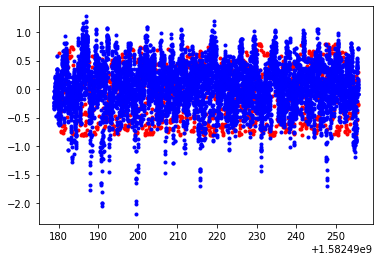

In [40]:
plt.plot(data_mpc['rostime'], data_mpc['at'], '.r')
plt.plot(data_raw['time'], data_raw['x_lin_acc'], '.b')

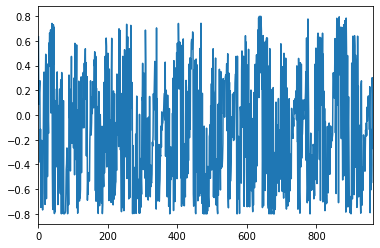

In [41]:
mpc_x_acc.plot()

In [42]:
#first_time = data_mpc['rostime'][0]
#data_mpc['time'] = [t-first_time for t in data_mpc['rostime']]

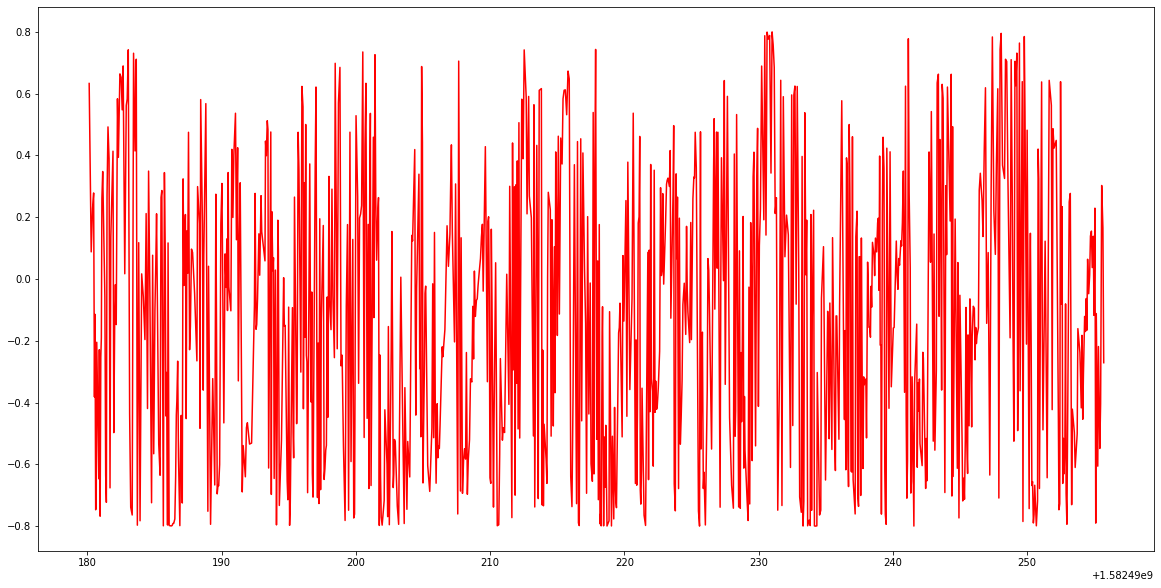

In [43]:
mpc_time = data_mpc['rostime']
mpc_x_acc = data_mpc['at']
mpc_y_acc = data_mpc['an']

#time_ = [t*1e-9 for t in time_]

fig = plt.figure(figsize=(20,10))
plt.plot(mpc_time, mpc_x_acc, '-r')

ValueError: x and y must have same first dimension, but have shapes (7000,) and (965,)

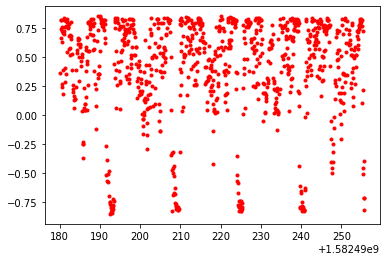

In [44]:
plt.plot(mpc_time, data_mpc['an'], '.r')
plt.plot(time_, mpc_y_acc, '.b')

# laps separately 

In [ ]:
x_laps = np.split(x_pos, global_end_turn_indexes)
y_laps = np.split(y_pos, global_end_turn_indexes)

speed_laps = np.split(speed, global_end_turn_indexes)

ax_laps = np.split(x_acc_, global_end_turn_indexes)
ay_laps = np.split(y_acc_, global_end_turn_indexes)
az_laps = np.split(z_acc_, global_end_turn_indexes)

a_res_laps = [x**2 + y**2 for x,y in zip(ax_laps, ay_laps)]


# total acceleration

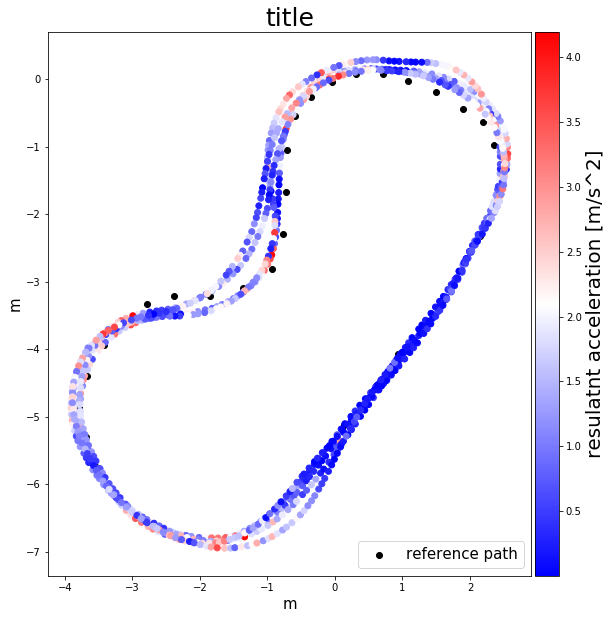

In [123]:
res_acc = [(x**2+y**2) for x,y in zip(avg_x_acc, avg_y_acc)]

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('title', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_avg, y_avg, c=res_acc, cmap='bwr')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(im, cax=cax)
cb.set_label('resulatnt acceleration [m/s^2]', fontsize=20)

ax.set_aspect('equal')


